In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import random
%matplotlib inline
#%matplotlib notebook
plt.style.use('ggplot')

In [2]:
#see all available columns
pd.set_option('display.max_columns', None)

#reads in each csv separately
pitches = pd.read_csv('../data/pitches.csv', low_memory=False)

atbats = pd.read_csv('../data/atbats.csv', low_memory=False)

ejections = pd.read_csv('../data/ejections.csv', low_memory=False)

games = pd.read_csv('../data/games.csv', low_memory=False)

names = pd.read_csv('../data/player_names.csv', low_memory=False)

Text(0, 0.5, 'Height of Pitch')

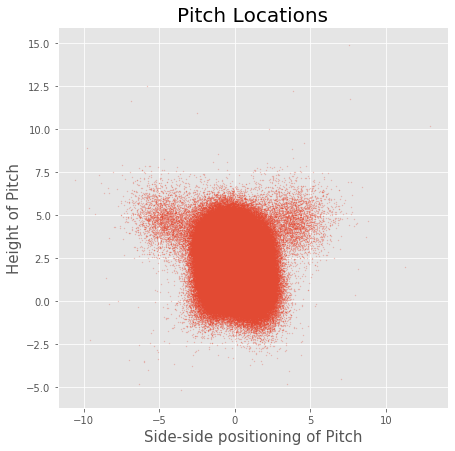

In [3]:
#plots pitch locations
plt.figure(figsize=(7,7))
plt.scatter(pitches['px'].values, pitches['pz'].values, alpha=0.2, s=1)
plt.title('Pitch Locations', size=20)
plt.xlabel('Side-side positioning of Pitch', size=15)
plt.ylabel('Height of Pitch', size=15)

In [4]:
pitches.shape

(2867154, 40)

In [5]:
atbats.shape

(740389, 11)

In [6]:
names.shape

(2218, 3)

In [7]:
ejections.shape

(761, 10)

In [8]:
games.shape

(9718, 17)

In [10]:
#finds all nans and uses np.where to grab axis [0] grabs first of tuple
rows_with_nans = np.where(pitches.isna().any(axis=1) == True)[0]

#new df with dropped nans, inplace=True
pitches.drop(index=rows_with_nans, axis=0, inplace=True)

#finds 'UN' in pitches and drops those rows
unknown_mask = np.where(pitches['pitch_type'] == 'UN')[0]
#drops the rows using the indicies from above
pitches.drop(index=unknown_mask, axis=0, inplace=True)

In [11]:
#19,000 total rows that have atleast one NaN in them
rows_with_nans.shape

(19904,)

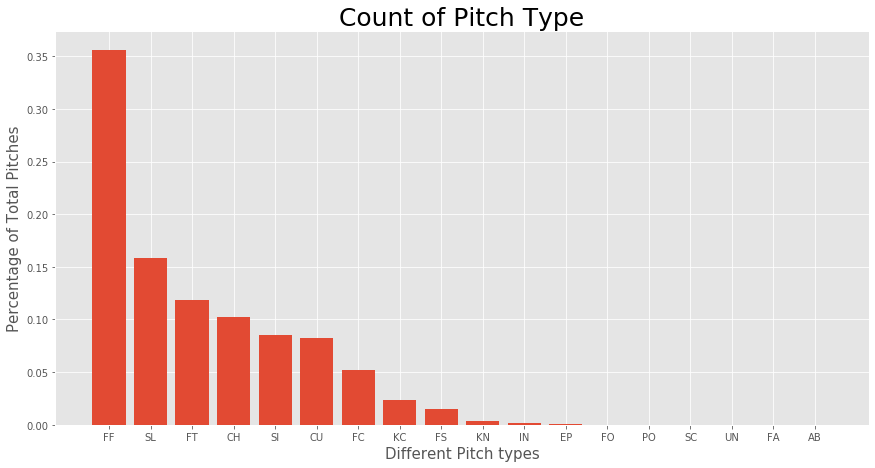

In [18]:
#x is the count of each pitch sorted
x = pitches.groupby('pitch_type').count().sort_values('px').iloc[:, 0].values[::-1]
#pitch is the index of different pitches
pitch = pitches.groupby('pitch_type').count().sort_values('px').iloc[:, 0].index[::-1]
plt.figure(figsize=(12,6))
plt.bar(pitch, x/np.sum(x))
plt.tight_layout()
plt.title('Count of Pitch Type', size=25)
plt.ylabel('Percentage of Total Pitches', size=15)
plt.xlabel('Different Pitch types', size=15)
plt.savefig('../Graphics/pitch_types.png', dpi=100)

In [175]:
#pca need to plot these compositions with every different pitch type and look to see a difference
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_comps = pca.fit_transform(pitches.iloc[:, :8])

In [176]:
#top 6 most common pitches
top_6_labels = pitches.groupby('pitch_type').count().sort_values('px').iloc[:, 0].index[::-1][:6]

#first feature of pca with 2 components
x = pca_comps[:, 0]
#second feature of pac with 2 components
y = pca_comps[:, 1]
#labels of each pitch type for each row in pitches
pitch_type = pitches['pitch_type'].values

Plot took 7.262526988983154 to show


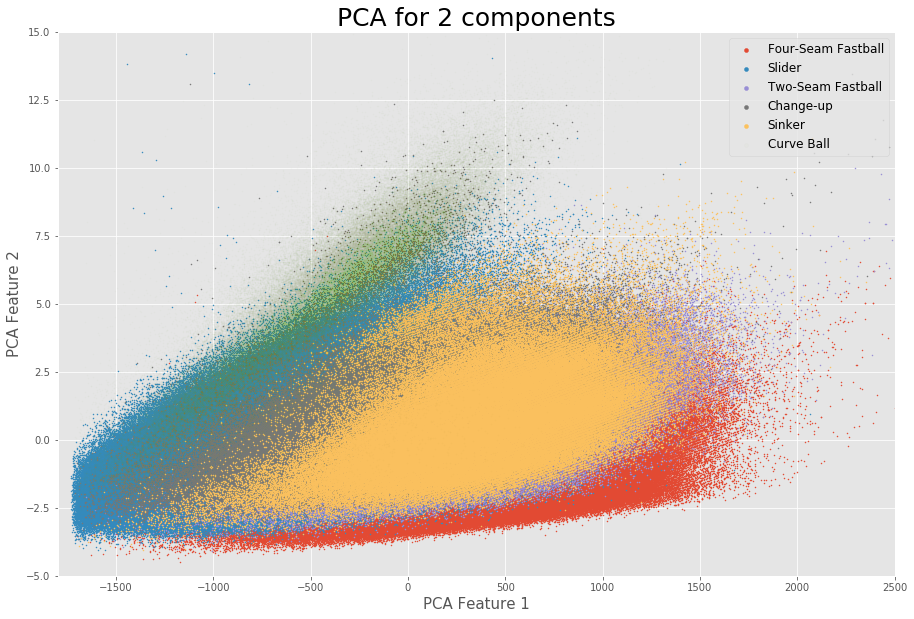

In [177]:
#grabs current time
current = time.time()
#dictionary to have nice plotting of types of pitches
dic = {'FF':'Four-Seam Fastball', 'SL': 'Slider', 'FT': 'Two-Seam Fastball', 'CH': 'Change-up', 'SI': 'Sinker', 'CU': 'Curve Ball'}


plt.figure(figsize=(15,10))
for label in top_6_labels:
    line = plt.scatter(x[pitch_type == label], y[pitch_type == label], label=label, s=1)
plt.title('PCA for 2 components', size=25)
line.set_alpha(0.02)
plt.xlabel('PCA Feature 1', size=15)
plt.ylabel('PCA Feature 2', size=15)
plt.ylim(-5, 15)
plt.xlim(-1800, 2500)
#plt.legend doesnt want to work??
plt.legend(loc=1, markerscale=4, fontsize='large', labels=dic.values())
plt.savefig('../Graphics/PCA_2comps.png', dpi=100);
print('Plot took {} to show'.format(time.time() - current))

## Takeaways from EDA
Predicting the pitch type based on the count, the pitcher, (the previous pitches??), the score, runners on 1st, 2nd, 3rd, the number of pitches thrown so far, pitcher left handed/right handed, the batter handedness, inning, so much more...

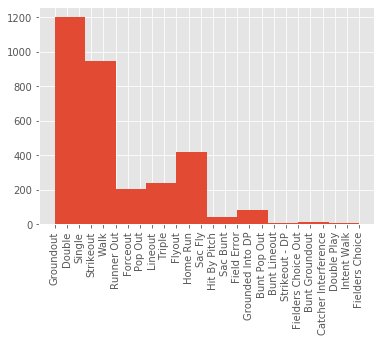

In [74]:
atbats[(atbats['pitcher_id'] == 452657)]['event'].hist()
plt.xticks(rotation=90);

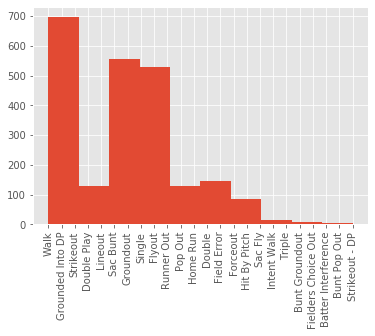

In [75]:
atbats[(atbats['pitcher_id'] == 448802)]['event'].hist()
plt.xticks(rotation=90);

In [76]:
#this pitcher has seen every batter on average of 6 times each 
atbats[(atbats['pitcher_id'] == 452657)] .groupby(['pitcher_id', 'batter_id']).count().mean()

ab_id       6.203523
event       6.203523
g_id        6.203523
inning      6.203523
o           6.203523
p_score     6.203523
p_throws    6.203523
stand       6.203523
top         6.203523
dtype: float64

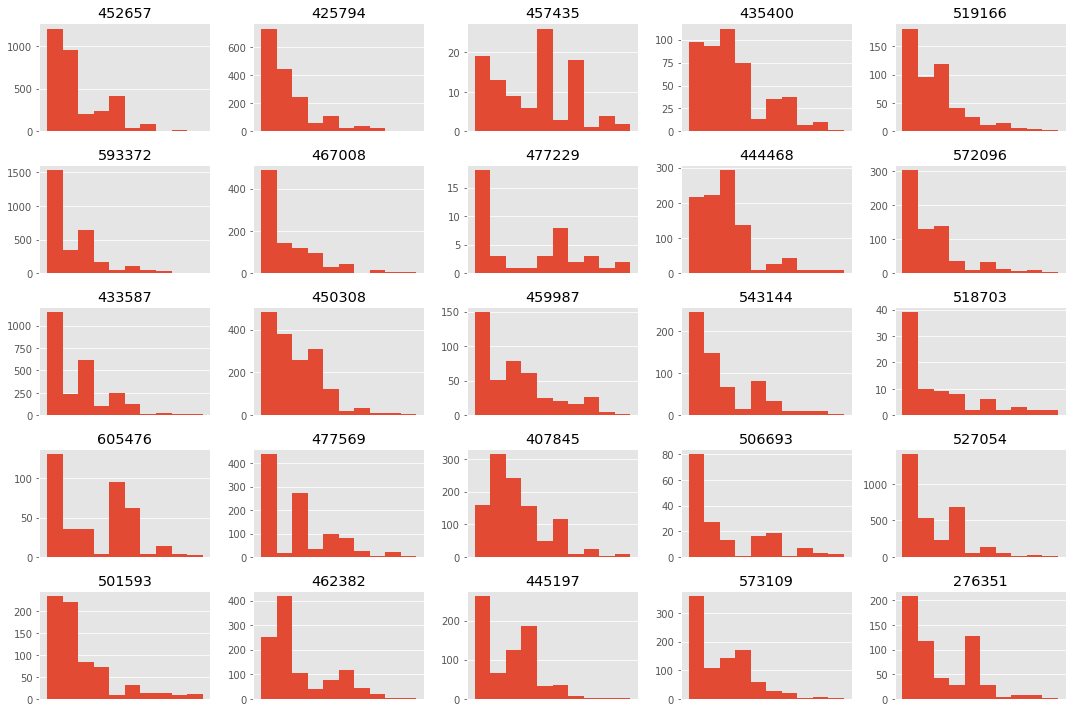

In [77]:
#looks at different pitchers and the results of all of the batters they see
fig, ax = plt.subplots(5, 5, figsize=(15, 10))
for pitcher, ax in zip(atbats['pitcher_id'].unique()[:50], ax.flatten()):
    ax.hist(atbats[atbats['pitcher_id'] == pitcher]['event'].values)
    ax.set_xticks([])
    ax.set_title(pitcher)
    
plt.tight_layout()
    

In [78]:
#in order to get a better picture lets merge atbats with pitches to see the different pictures
game_sit = pd.merge(atbats, pitches[['px', 'pz', 'start_speed', 'end_speed', 'spin_rate', 'spin_dir', 'break_angle', 'break_length', 'code', 'type', 'pitch_type', 'b_score', 'b_count', 's_count', 'outs', 'pitch_num', 'on_1b', 'on_2b', 'on_3b', 'ab_id']], on='ab_id')

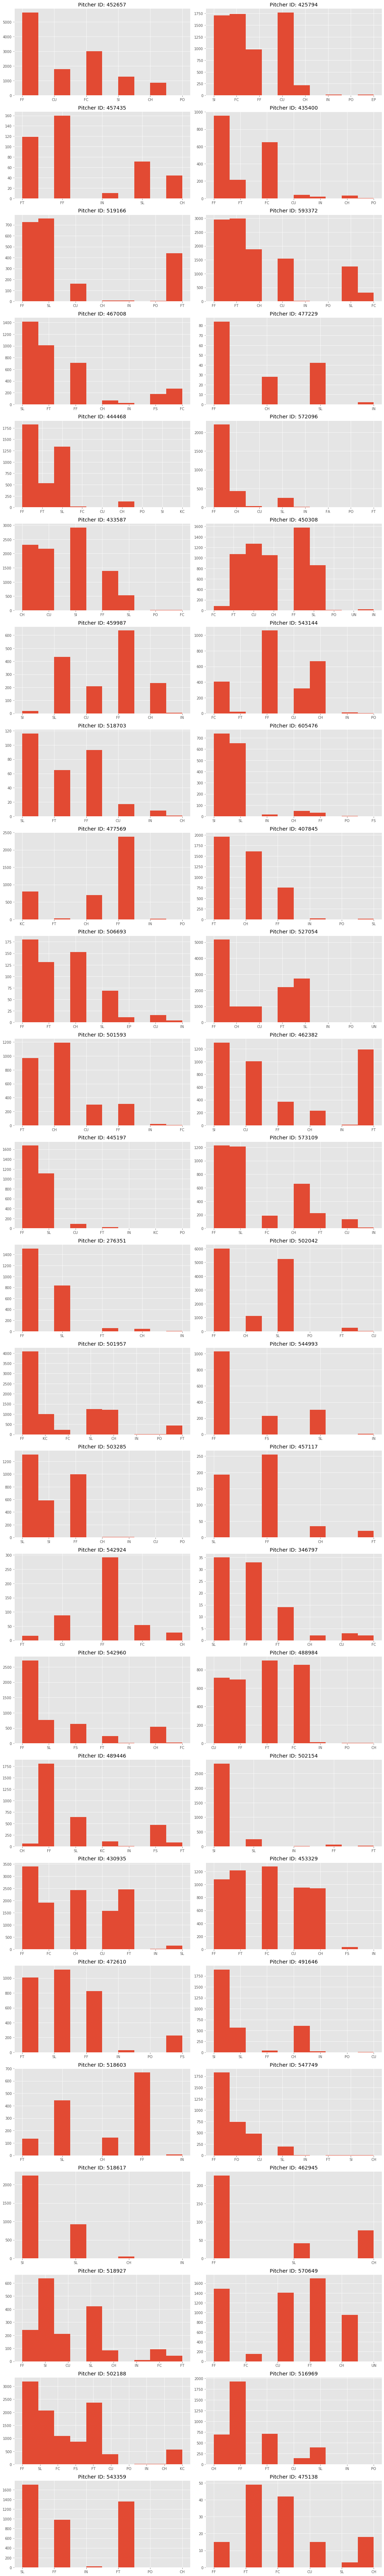

In [79]:
#looks at first 50 pitchers and observes their pitch types
fig, ax = plt.subplots(25, 2, figsize=(15, 100))
no_nan_df = game_sit.replace(np.nan, 'None')
for pitcher, ax in zip(atbats['pitcher_id'].unique()[:50], ax.flatten()):
    ax.hist(no_nan_df[no_nan_df['pitcher_id'] == pitcher]['pitch_type'])
    #ax.set_xticks()
    ax.set_title('Pitcher ID: {}'.format(pitcher))
    
plt.tight_layout() 

Text(0, 0.5, 'Number of Pitches')

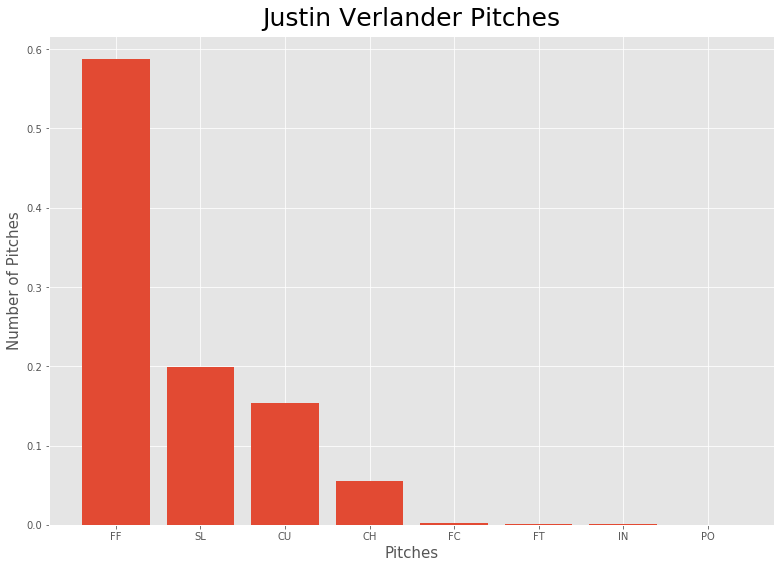

In [80]:
#looks at one pitchers distribution of pitches
nums = no_nan_df[no_nan_df['pitcher_id'] == 434378].groupby('pitch_type').count().sort_values('ab_id', ascending=False)['ab_id'].values
pitch_type = no_nan_df[no_nan_df['pitcher_id'] == 434378].groupby('pitch_type').count()[['ab_id']].sort_values('ab_id', ascending=False).index
plt.figure(figsize=(13,9))
plt.bar(pitch_type, nums/np.sum(nums))
plt.title('Justin Verlander Pitches', size=25, pad=10)
plt.xlabel('Pitches', size=15)
plt.ylabel('Number of Pitches', size=15)
#plt.savefig('../Graphics/Verlander_pitches.png', dpi=100);

Text(0, 0.5, 'Percent of Total Pitches')

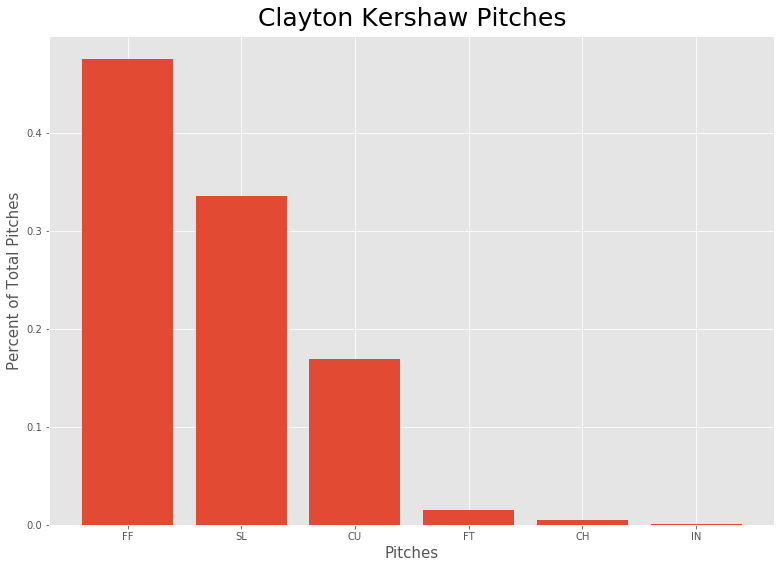

In [81]:
#Kershaw pitches
nums = no_nan_df[no_nan_df['pitcher_id'] == 477132].groupby('pitch_type').count().sort_values('ab_id', ascending=False)['ab_id'].values
pitch_type = no_nan_df[no_nan_df['pitcher_id'] == 477132].groupby('pitch_type').count()[['ab_id']].sort_values('ab_id', ascending=False).index
plt.figure(figsize=(13,9))
plt.bar(pitch_type, nums / np.sum(nums))
plt.title('Clayton Kershaw Pitches', size=25, pad=10)
plt.xlabel('Pitches', size=15)
plt.ylabel('Percent of Total Pitches', size=15)
#plt.savefig('../Graphics/Kershaw_pitches.png', dpi=100);

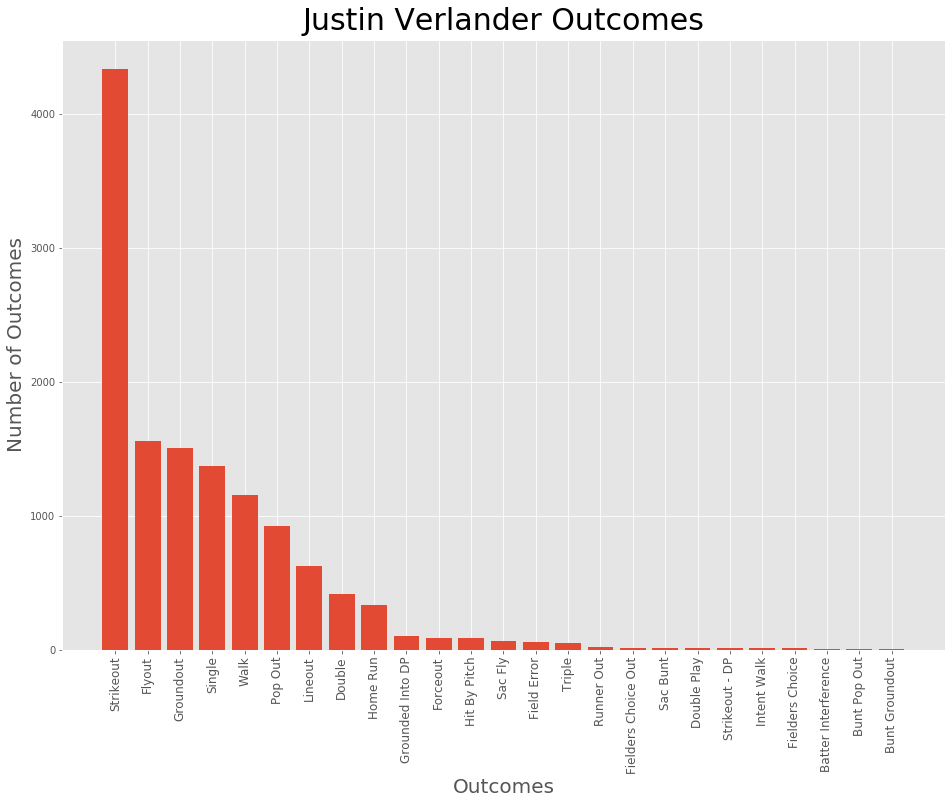

In [82]:
#distribution of outcomes of pitches
nums = no_nan_df[no_nan_df['pitcher_id'] == 434378].groupby('event').count().sort_values('ab_id', ascending=False)['ab_id'].values
outcome = no_nan_df[no_nan_df['pitcher_id'] == 434378].groupby('event').count().sort_values('ab_id', ascending=False)['ab_id'].index

plt.figure(figsize=(13,9))
plt.bar(outcome, nums)
plt.tight_layout()
plt.ylabel('Number of Outcomes', size=20)
plt.xlabel('Outcomes', size=20)
plt.title('Justin Verlander Outcomes', size=30, pad=10)
plt.xticks(rotation=90, size=12);


In [83]:
#creates full name column inside names df
names['full_name'] = names['first_name'] + ' ' + names['last_name']
#merges names with game situation df 
merged_names = pd.merge(names[['full_name', 'id']], game_sit, left_on='id', right_on='batter_id')
#merges the above merged names with the pitcher id now
final_play_df = pd.merge(merged_names, names[['full_name', 'id']], left_on='pitcher_id', right_on='id')
#renames some of the merged column names, and drops other id_x and id+y columns
final_play_df = final_play_df.rename(columns={'full_name_x':'batter_name', 'g_id':'game_id', 'o' :'post_outs', 'stand':'batter_stand', 'full_name_y':'pitcher_name'}).drop(columns=['id_x', 'id_y'])

In [84]:
#grabs columns that make sense
final_play_df = final_play_df[['pitcher_name', 'batter_name', 'ab_id', 'batter_id', 'pitcher_id', 'game_id', 'inning', 'p_score', 'p_throws', 'batter_stand', 'top', 'b_score', 'b_count', 's_count', 'outs', 'pitch_num', 'on_1b', 'on_2b', 'on_3b', 'pitch_type']]
#replaces R and L with 1's and 0's
final_play_df.replace({'R': 1, 'L': 0}, inplace=True)

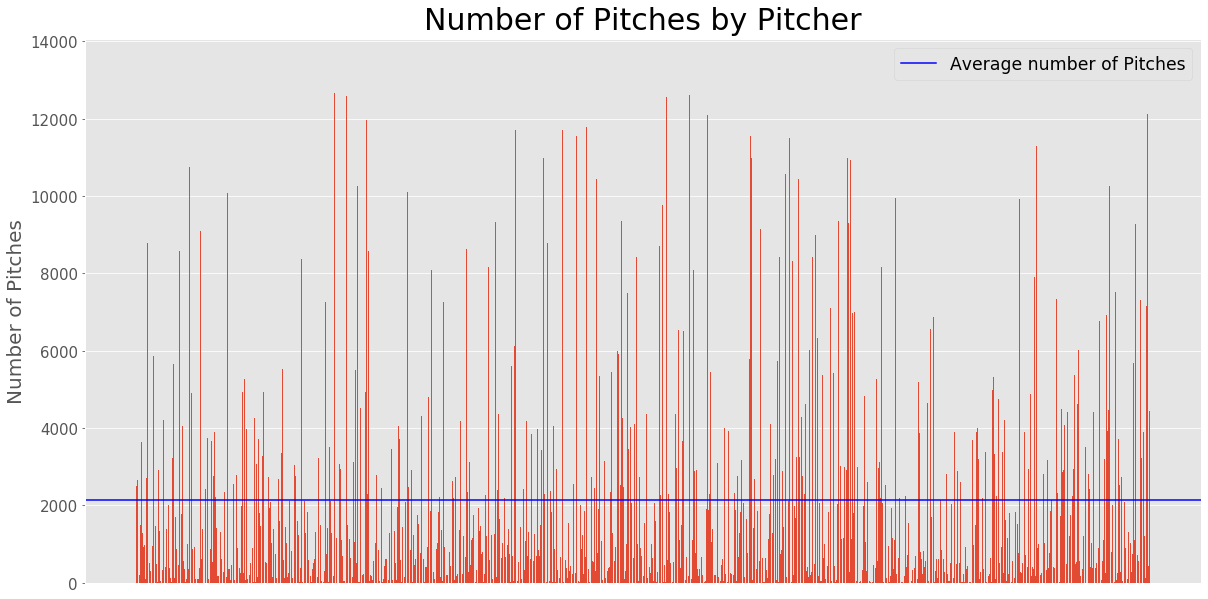

In [120]:

index = final_play_df.groupby('pitcher_name').count().iloc[:, 0].index
nums = final_play_df.groupby('pitcher_name').count().iloc[:, 0].values
mean_nums = np.mean(nums)

plt.figure(figsize=(20,10))
plt.title('Number of Pitches by Pitcher', size=30, pad=10)
plt.bar(index, nums)
plt.axhline(mean_nums, c='b', label='Average number of Pitches')
plt.xticks([])
plt.yticks(size=15)
plt.ylabel('Number of Pitches', size=20)
plt.legend(fontsize='xx-large');

In [167]:
pitchers_5000 = final_play_df.groupby('pitcher_name').count().iloc[:, 0][final_play_df.groupby('pitcher_name').count().iloc[:, 0] > 5000].index

In [145]:
random.seed(2725)
random.choices(final_play_df['pitcher_name'], k=10)

['Cole Hamels',
 'Danny Duffy',
 'Marco Estrada',
 'Gerrit Cole',
 'Ross Detwiler',
 'Scott Kazmir',
 'Jake Barrett',
 'Andrew Miller',
 'Jhoulys Chacin',
 'Jeanmar Gomez']

In [171]:
final_play_df.groupby('pitcher_name').count().iloc[:, 0][final_play_df.groupby('pitcher_name').count().iloc[:, 0] > 5000].index

Index(['Aaron Nola', 'Aaron Sanchez', 'Adam Conley', 'Adam Wainwright',
       'Adam Warren', 'Alex Cobb', 'Alex Wood', 'Andrew Cashner',
       'Anibal Sanchez', 'Anthony DeSclafani',
       ...
       'Vince Velasquez', 'Wade Miley', 'Wei-Yin Chen', 'Wily Peralta',
       'Yordano Ventura', 'Yovani Gallardo', 'Yu Darvish', 'Zach Davies',
       'Zack Godley', 'Zack Greinke'],
      dtype='object', name='pitcher_name', length=160)

In [172]:
def model_each_pitcher(estimator, num_pitchers=5, binary:bool=True, randomseed=True):
    if randomseed:
        random.seed(2527)
    
    #lst_pitchers = random.choices(final_play_df['pitcher_name'], k=num_pitchers)
    lst_pitchers = random.choices(final_play_df.groupby('pitcher_name').count().iloc[:, 0][final_play_df.groupby('pitcher_name').count().iloc[:, 0] > 5000].index, k=num_pitchers)
    cross_val_accscores = {}
    for pitcher in lst_pitchers:
        df = final_play_df[final_play_df['pitcher_name'] == pitcher]
        df = pd.merge(df, pd.get_dummies(df['batter_name']),left_index=True, right_index=True).drop(columns=['pitcher_name', 'batter_name', 'ab_id', 'batter_id', 'pitcher_id', 'game_id'])
        thresh = round(df.shape[0] * 0.757)
        Xtrain = df.drop(columns='pitch_type').iloc[:thresh, :]
        if binary == False:
            ytrain = df['pitch_type'][:thresh]
        ytrain = np.where(df['pitch_type'][:thresh] == 'FF', 1, 0)
        
        cross_val_accscores[pitcher] = [cross_val(estimator, Xtrain.values, ytrain), df.shape[0]] 
    return cross_val_accscores

In [173]:
model_each_pitcher(LogisticRegression(solver='sag'))

/Users/morganabbitt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/morganabbitt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/morganabbitt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/morganabbitt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/morganabbitt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:3

{'Madison Bumgarner': [0.7272300189559064, 10559],
 'Charlie Morton': [0.8487693710118507, 7246],
 'Jacob deGrom': [0.6455510942986014, 11699],
 'Yu Darvish': [0.6953144266337855, 5357],
 'Clayton Kershaw': [0.6665807698502174, 10253]}

In [137]:
justin_verlander_df = final_play_df[final_play_df['pitcher_name'] == 'Justin Verlander']
justin_verlander_df = pd.merge(justin_verlander_df, pd.get_dummies(justin_verlander_df['batter_name']),left_index=True, right_index=True).drop(columns=['pitcher_name', 'batter_name', 'ab_id', 'batter_id', 'pitcher_id', 'game_id'])
jv_Xtrain = justin_verlander_df.drop(columns='pitch_type').iloc[:9576, :]
jv_ytrain = justin_verlander_df['pitch_type'][:9576,]
jv_binary_ytrain = np.where(jv_ytrain == 'FF', 1, 0)

In [138]:
#justin verlander cross validation score with 2 classes four seam fastball or not 
#definitely losing some signal with 2 classes but too much signal with all 15 classes.
model = cross_val(LogisticRegression(solver='sag'), jv_Xtrain.values, jv_binary_ytrain)

/Users/morganabbitt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/morganabbitt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/morganabbitt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/morganabbitt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Accuracy Mean Score of LogisticRegression: 0.647


/Users/morganabbitt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [85]:
#uses get dummies on pitcher names to create new features
pitch_names = pd.get_dummies(final_play_df['pitcher_name'])

In [87]:
#takes a long time to run
#merges class_modeling with the new pitch names, drops the redundant columns 
#drops one of the pitchers from the df using random.choice 
df = final_play_df.merge(pitch_names, left_index=True, right_index=True).drop(columns=['ab_id', 'pitcher_name', 'batter_name', 'batter_id', 'pitcher_id', 'game_id', random.choice(pitch_names.columns)])

In [ ]:
#moving to Logistic regression for base model
from sklearn.linear_model import LogisticRegression

#80-20 train test split
X_train = df.drop(columns='pitch_type').iloc[:100000, :]
y_train = df['pitch_type'][:100000]

X_test = df.drop(columns='pitch_type').iloc[100000:125000, :]
y_test = df['pitch_type'][100000:125000]

In [158]:
#moving to Logistic regression for base model
from sklearn.linear_model import LogisticRegression
lg = LogisticRegression(solver='lbfgs', multi_class='multinomial')
#model = lg.fit(X_train.values, y_train.values)

In [101]:
from sklearn.model_selection import KFold
#binary 2 class classification use 'sag'
#X_train = df.drop(columns='pitch_type').iloc[:100000, :]
#y_train = df['pitch_type'][:100000]
y_train_FF = np.where(y_train == 'FF', 1, 0)
model = cross_val(LogisticRegression(solver='sag'), X_train.values, y_train_FF)
#0.67 CV accuracy

/Users/morganabbitt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/morganabbitt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/morganabbitt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/morganabbitt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/morganabbitt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:3

Accuracy Mean Score of LogisticRegression: 0.674


In [19]:
def cross_val(estimator, X, y):
    '''
    estimator = The model you want to use with the sepcified paramters
                        ex: LogisticRegression(), RandomForestClassification() ...
                        
    data = clean dataframe you are working with, no nans
    
    clean_features = list of features you want to observe in your model
    
    target = target column you want to predict against
    '''

    kf = KFold(n_splits=5, shuffle=True)  # almost always use shuffle=True
    acc_scores = []
    #f1_scores = []
    model = estimator   
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        model.fit(X_train, y_train)
        y_test_pred = model.predict(X_test)
        acc_scores.append(model.score(X_test, y_test))
        
        #change micro to weighted?
        #f1_scores.append(f1_score(y_test, y_test_pred, average='macro'))
        #f1_scores.append(f1_score(y_test, y_test_pred, average='weighted'))
        #f1_scores.append(f1_score(y_test, y_test_pred, average='micro'))

    #print('F1 Mean Score of {}: {:.3f}'.format(type(model).__name__, np.mean(f1_scores)))
    #print('Accuracy Mean Score of {}: {:.3f}'.format(type(model).__name__, np.mean(acc_scores)))
    #print('Recall Mean Score of {} : {:.3f}'.format(type(model).__name__, np.mean(recall_scores)))
    #print('Precision Mean Score of {} : {:.3f}'.format(type(model).__name__, np.mean(precision_scores)))
    return np.mean(acc_scores) 